# <center> Финальный проект <br> Идентификация пользователей по посещенным веб-страницам


### Цель
- Определить по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, Элис это или взломщик (кто-то другой)

### Задачи
- Построить наиболее эффективную модель для достижения цели
- Сделать прогнозы для сессий в тестовой выборке

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.sparse import hstack

### Данные
В обучающей выборке:

- Признаки site_i – это индексы посещенных сайтов (расшифровка дана в файле со словарем)
- Признаки time_j – время посещения сайтов site_j
- Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.

In [2]:
# Загрузим данные
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату и создавать признаки сразу для обеих выборок. Индексы сайтов нумеровались с 1, так что заменим пропуски на нули

In [5]:
train_test_df = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно, поэтому в качестве метрики будем использовать площадь под кривой ошибок - ROC AUC

In [7]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Создадим разреженные матрицы, используя объединенную матрицу *train_test_df_sites*, потом разделим обратно на обучающую и тестовую части

Выделим в отдельный вектор *y* ответы на обучающей выборке

In [8]:
# функция удаления столбца из разреженной матрицы, необходима для удаления столбца для сайта с индексом ноль
def dropcols_coo(M, idx_to_drop):
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col) 
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

In [9]:
# функция преобразования матрицы в разреженный формат
def sparse(d):
    rows = []
    columns = []
    data = []
    for i in tqdm(xrange(d.shape[0])):
        unique, counts = np.unique(d[i], return_counts=True)
        dic = dict(zip(unique, counts))
        rows.extend([i]*len(dic.keys()))
        columns.extend(dic.keys())
        data.extend(dic.values())
    c = csr_matrix((data, (rows, columns)))
    
    return dropcols_coo(c, 0)

In [10]:
train_test_sparse = sparse(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:253561]
X_test_sparse = train_test_sparse[253561:]
y = train_df['target']

100%|███████████████████████████████| 336358/336358 [00:22<00:00, 14649.10it/s]


In [11]:
X_train_sparse.shape

(253561, 48371)

Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь

In [12]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Создадим объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и обучим модель на выборке `(X_train, y_train)`

In [13]:
sgd_logit_base = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit_base.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*

In [14]:
logit_valid_pred_proba = sgd_logit_base.predict_proba(X_valid)

Посчитаем ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке

In [15]:
round(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]), 3)

0.934

## Создание новых признаков

Попробуем улучшить модель с помощью добавления признаков

Создадим следующие признаки:
- unique - количество уникальных сайтов за сессию
- site_max_count - сайт наиболее часто встречающийся за сессию (если таких несколько, то первый из них)
- com_count - количество сайтов за сессию с расширением .com
- org_count - количество сайтов за сессию с расширением .org
- fr_count - количество сайтов за сессию с расширением .fr
- net_count - количество сайтов за сессию с расширением .net
- morning - сессия начинается утром
- day - сессия начинается днем
- evening - сессия начинается вечером
- night - сессия начинается ночью
- dayofweek - день недели начала сессии
- month - месяц начала сессии
- weekend - относится ли день начала сессии к выходному дню
- top10 - количество сайтов в сессии, которые входят в топ10 самых популярных сайтов в выборке

In [16]:
# названия признаков
features_names = ['unique', 'site_max_count', 'com_count', 'fr_count',
                  'org_count', 'net_count', 'day', 'night', 'evening', 
                  'morning', 'dayofweek', 'month', 'weekend', 'top10']

In [17]:
#создание признака top10
freq = np.unique(train_test_df_sites.values, return_counts = True)
f = list(freq[1])
f.sort(reverse=True)
f1 = f[1:11]
top=[]
for i in f1:
    top.append(freq[0][list(freq[1]).index(i)])
top10 =[]
for i in tqdm(range(len(train_test_df_sites))):
    top10.append(len(np.intersect1d(train_test_df_sites.loc[i], top)))


100%|████████████████████████████████| 336358/336358 [02:06<00:00, 2653.04it/s]


In [18]:
# сoздание признаков site_max_count и unique 
site_max_count=[]
unique=[]
for k in tqdm(range(len(train_test_df_sites.values))):  
    s = list(train_test_df_sites.values[k])
    t=set(s)
    t-={0}
    unique.append(len(t))
    m = None
    q_max = 0
    for item in set(s):
        q = s.count(item)
        if q > q_max:
            q_max = q
            m = item
    site_max_count.append(m)

100%|███████████████████████████████| 336358/336358 [00:13<00:00, 25652.68it/s]


In [19]:
#создание признаков dayofweek, month, morning, day, evening, night
t = pd.to_datetime(train_test_df['time1'])
hour = t.apply(lambda s: s.hour)
dayofweek=t.apply(lambda s: s.dayofweek)
month = t.apply(lambda s: s.month)
morning = ((hour >= 7) & (hour <= 11)).astype('int')
day = ((hour >= 12) & (hour <= 18)).astype('int')
evening = ((hour >= 19) & (hour <= 23)).astype('int')
night = ((hour >= 0) & (hour <= 6)).astype('int')
                    

In [20]:
#создание признака weekend
weekend=[]
for i in dayofweek:
    if i >5:
        weekend.append(1)
    else:
        weekend.append(0)

In [21]:
#загрузим словарь с сайтами
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as s:
        d = pickle.load(s)

d1 = {v:k for k, v in d.items()}
d1[0]=0

In [22]:
#отделим от каждого сайта расширение
tts = train_test_df_sites.values
r = []  
for k in tqdm(range(len(tts))):  
    for i in range(10):
        if d1[tts[k][i]] != 0:
              r.append(d1[tts[k][i]].split('.')[-1])
        else:
              r.append(0)    

100%|███████████████████████████████| 336358/336358 [00:21<00:00, 15970.66it/s]


In [23]:
#создание признаков com_count, fr_count, org_count, net_count
r = np.array(r).reshape((336358, 10))
com_count = []
fr_count = []
org_count = []
net_count = []
for i in tqdm(range(len(r))):
    com_count.append(list(r[i]).count('com'))
    fr_count.append(list(r[i]).count('fr'))
    org_count.append(list(r[i]).count('org'))
    net_count.append(list(r[i]).count('net'))


100%|███████████████████████████████| 336358/336358 [00:12<00:00, 27983.19it/s]


In [24]:
# список признаков
features = [unique, site_max_count, com_count, fr_count,
            org_count, net_count, day, night, evening, 
            morning, dayofweek, month, weekend, top10]

In [25]:
#добавим в train_test_df_sites все признаки
for i, k in enumerate(features):
    train_test_df_sites[features_names[i]]=features[i]

In [26]:
#выделим из train_test_df_sites обучающую выборку с ответами
train_df_new = train_test_df_sites[:253561]
train_df_new['target']=np.array(train_df['target'])

**Посмотрим на гистограммы распределений признаков для Элис (darkviolet) и остальных пользователей (pink)**

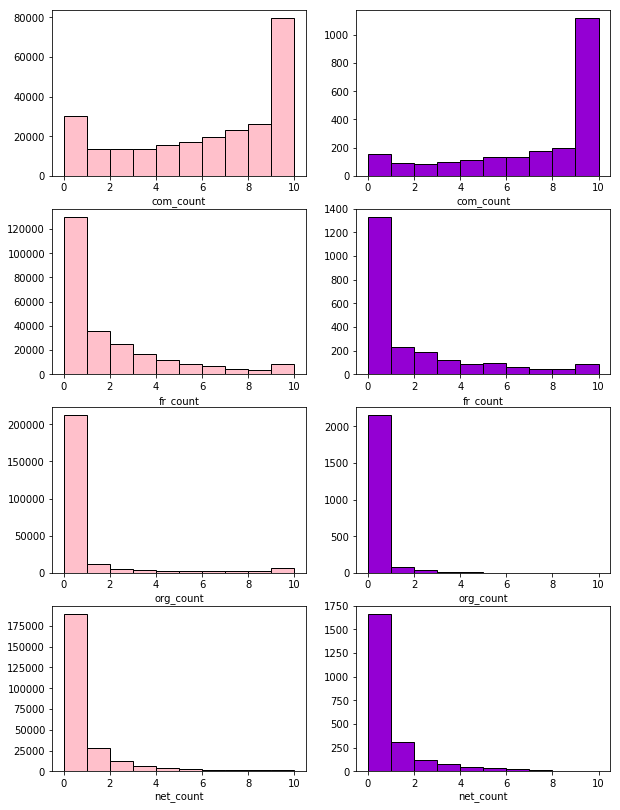

In [27]:
#построим гимтограммы для признаков com_count, fr_count, org_count, net_count
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 14))
t=1
color_dic = {0: 'pink', 1 : 'darkviolet'}
for i, k in enumerate(features_names[2:6]):
    for idx, (u, sub_df) in  enumerate (pd.groupby(train_df_new, 'target')):
        a = plt.subplot(4, 2, t)
        plt.hist(sub_df[k], color=color_dic[u], edgecolor='black')
        plt.xlabel(k)
        t=t+1

По этим признакам Элис и остальные пользователи почти не отличаются. Наиболее заметные различия видны для признака org_count. В отличие от остальных Элис реже заходит на сайты с таким расширением доменного имени

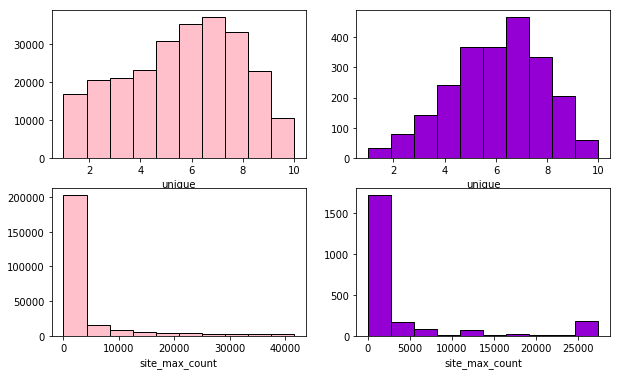

In [28]:
#построим гимтограммы для признаков unique, site_max_count
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
t=1
color_dic = {0: 'pink', 1 : 'darkviolet'}
for i, k in enumerate(features_names[0:2]):
    for idx, (u, sub_df) in  enumerate (pd.groupby(train_df_new, 'target')):
        a = plt.subplot(2, 2, t)
        plt.hist(sub_df[k], color=color_dic[u], edgecolor='black')
        plt.xlabel(k)
        t=t+1

Для этих признаков тоже сильных различий не наблюдается

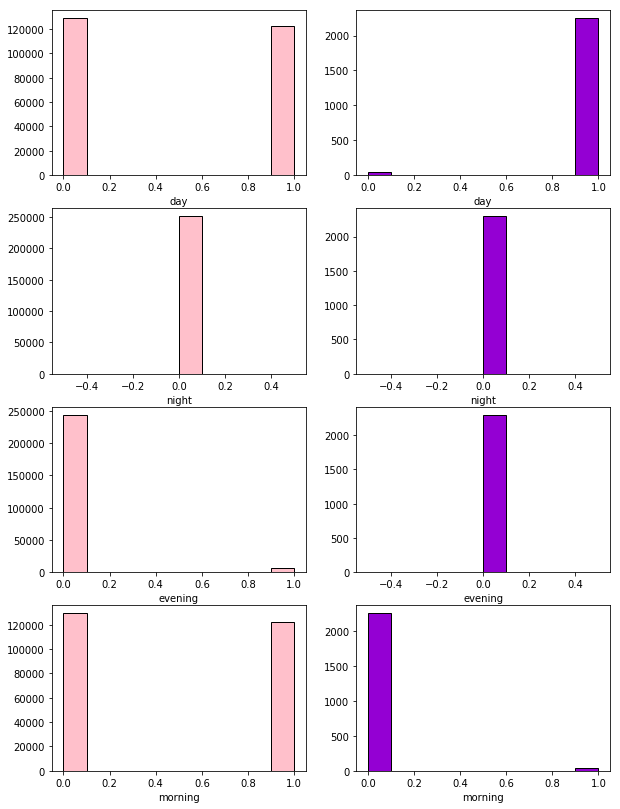

In [29]:
#построим гимтограммы для признаков day, night, evening, morning
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 14))
t=1
color_dic = {0: 'pink', 1 : 'darkviolet'}
for i, k in enumerate(features_names[6:10]):
    for idx, (u, sub_df) in  enumerate (pd.groupby(train_df_new, 'target')):
        a = plt.subplot(4, 2, t)
        plt.hist(sub_df[k], color=color_dic[u], edgecolor='black')
        plt.xlabel(k)
        t=t+1

Для этих признаков уже лучше видны различия для Элис и остальных пользователей. Элис почти всегда посещает сайты днем, очень редко утром и вечером. Именно эти признаки должны улучшить модель

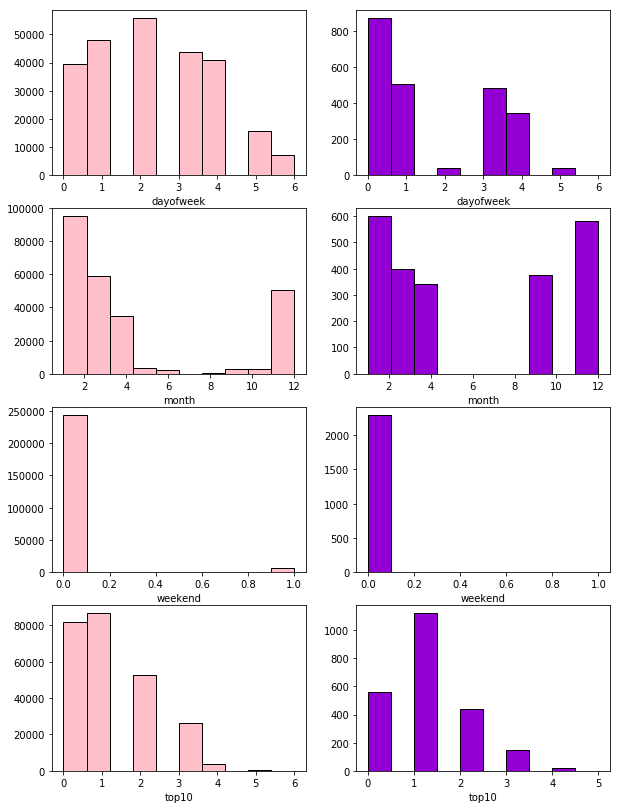

In [30]:
#построим гимтограммы для признаков dayofweek, month, weekend, top10
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 14))
t=1
color_dic = {0: 'pink', 1 : 'darkviolet'}
for i, k in enumerate(features_names[10:14]):
    for idx, (u, sub_df) in  enumerate (pd.groupby(train_df_new, 'target')):
        a = plt.subplot(4, 2, t)
        plt.hist(sub_df[k], color=color_dic[u], edgecolor='black')
        plt.xlabel(k)
        t=t+1

Для этих признаков тоже видны отличия. Элис чаще посещает сайты в будние дни. В будние дни реже всего заходит в сеть в среду, хотя остальные пользователи чаще всего посещают сайты в среду. Чуть менее сильные различия видны по месяца и количеству сайтов в сессии, входящих в топ10

**Посмотрим как меняется ROC AUC при добавление каждого из признаков по отдельности**

In [31]:
def sgd_logit(train_test_sparse):
    X_train_sparse = train_test_sparse[:253561]
    X_test_sparse = train_test_sparse[253561:]
    y = train_df['target']
    train_share = int(.7 * X_train_sparse.shape[0])
    X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
    X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
    sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
    sgd_logit.fit(X_train, y_train)
    logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)
    print(round(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]), 3))

In [32]:
for i in features_names:
    train_test_sparse1 = hstack((train_test_sparse, np.array(train_test_df_sites[i])[:,None]), format= 'csr')
    print(i)
    sgd_logit(train_test_sparse=train_test_sparse1)

unique
0.921
site_max_count
0.474
com_count
0.921
fr_count
0.918
org_count
0.933
net_count
0.932
day
0.949
night
0.934
evening
0.934
morning
0.958
dayofweek
0.925
month
0.922
weekend
0.935
top10
0.934


Лучшие значения (которые больше, чем ROC AUC для модели без признаков) показали признаки day, morning

В обучении будем использовать признаки: weekend, org_count, month, evening, unique, day, morning, top10. Данная модель должна наиболее точно идентифицировать Элис

In [33]:
train_test_sparse1 = hstack((train_test_sparse, np.array(train_test_df_sites['evening'])[:,None],
                             np.array(train_test_df_sites['month'])[:,None],
                             np.array(train_test_df_sites['unique'])[:,None],
                             np.array(train_test_df_sites['weekend'])[:,None],
                             np.array(train_test_df_sites['day'])[:,None],
                             np.array(train_test_df_sites['org_count'])[:,None],
                             np.array(train_test_df_sites['top10'])[:,None],
                             np.array(train_test_df_sites['morning'])[:,None]),
                             format= 'csr')


In [34]:
sgd_logit(train_test_sparse=train_test_sparse1)

0.961


## Обучение модели

Для кросс-валидации будем использовать TimeSeriesSplit, так как данные распределены по времени

In [35]:
time_split = TimeSeriesSplit(n_splits=10)

Разобъем данные обратно на обучение и тест

In [36]:
X_train_sparse = train_test_sparse1[:253561]
X_test_sparse = train_test_sparse1[253561:]

Обучим модель и подберем параметр альфа

In [37]:
sgd_logit = SGDClassifier(loss="log", random_state=17, n_jobs=-1)

sgd_params = {'alpha': [0.00001, 0.00002, 0.00004, 0.00006, 0.00008, 0.0001]}
sgd_grid = GridSearchCV(sgd_logit,sgd_params,cv=time_split, scoring='roc_auc')
sgd_grid.fit(X_train_sparse, y)
alpha=sgd_grid.best_params_["alpha"]
print(alpha)

8e-05


Построим кривые валидации

In [40]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

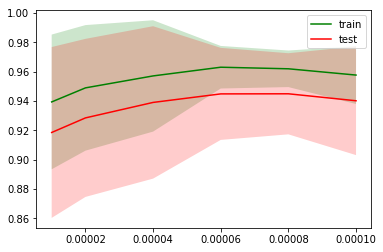

In [41]:
plot_validation_curves(sgd_params['alpha'], sgd_grid.cv_results_)

Тестовые значение получились достаточно высокие. С ростом качества при обучении, качество модели на тесте тоже увеличивается.

Постороим кривые обучения

In [42]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [43]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = sgd_grid.best_estimator_
n_train, val_train, val_test = learning_curve (estimator, 
                                              X_train_sparse, y, 
                                              train_sizes=train_sizes, 
                                              cv=time_split, 
                                              n_jobs=-1)

Wall time: 34.6 s


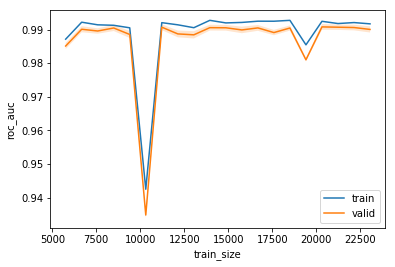

In [44]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='roc_auc')

Мы видим два ухудшения качества модели, но в целом на больших данных модель также показывает хорошие результаты.

Предскажем значения для тестовой выборки

In [45]:
test_pred = sgd_grid.predict_proba(X_test_sparse)

Результат ROC AUC, полученный для тестовой выборки, равен 0.94604 (то есть результат полученный на лидерборде соревнования на Kaggle)

**Качество модели получилось достаточно хорошее. Задачи данного типа встречаются в практике достаточно часто. Например, компания Яндекс решает такого типа задачу для идентификации взломщика почтового ящика по его поведению. То есть, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Поэтому необходимо максимально точно идентифицировать пользователей**

**Для улучшения качества модели можно поробовать использовать LogisticRegression, которая обрабатывает данные гораздо дольше, чем SGDClassifier. Еще можно попробовать создать признаки связанные со временем (продолжительность сессии; сайт, на котором пользователь больше всего проводит времени за сессию и тд)**